In [1]:
import os, json
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Optional
import re
import joblib
import torch
from torch import nn

In [2]:
# Modelo
class NumericTokenizer(nn.Module):
    """Mapea features numéricas a tokens: token_i = x_i * W_i + b_i"""
    def __init__(self, n_features: int, d_token: int):
        super().__init__()
        self.weight = nn.Parameter(torch.empty(n_features, d_token))
        self.bias = nn.Parameter(torch.zeros(n_features, d_token))
        nn.init.xavier_uniform_(self.weight)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, F) -> (B, F, D)
        return x.unsqueeze(-1) * self.weight + self.bias

class FTTransformer(nn.Module):
    def __init__(self, n_features: int, d_token: int, n_layers: int, n_head: int, ff_mult: int, dropout: float):
        super().__init__()
        self.tokenizer = NumericTokenizer(n_features, d_token)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_token))
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_token,
            nhead=n_head,
            dim_feedforward=d_token * ff_mult,
            dropout=dropout,
            batch_first=True,
            activation="gelu",
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.head = nn.Sequential(
            nn.LayerNorm(d_token),
            nn.Linear(d_token, d_token),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_token, 1),
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B = x.size(0)
        tokens = self.tokenizer(x)                  # (B, F, D)
        cls = self.cls_token.expand(B, -1, -1)     # (B, 1, D)
        x_tok = torch.cat([cls, tokens], dim=1)    # (B, 1+F, D)
        x_enc = self.encoder(x_tok)                # (B, 1+F, D)
        cls_out = x_enc[:, 0, :]                   # (B, D)
        y = self.head(cls_out).squeeze(-1)         # (B,)
        return y

### SHAP Modelo Base FT-Transformer

In [3]:
VERSION_TAG_FTT = "v1" 
BASE_FTT = "models_FTT"

# Configuración básica del dataset
df_vcr_c = pd.read_csv('dataset_vcr_compact.csv')
df_vcr_c = df_vcr_c[df_vcr_c['monto'] < 56000].copy()
df_vcr_c['log_monto']=np.log(df_vcr_c['monto'])

df_base =df_vcr_c.copy()
obj_cols = df_base.select_dtypes(include=["object"]).columns
cols_to_drop = list(obj_cols) + ["id", "latitud", "longitud"]
df_base = df_base.drop(columns=cols_to_drop)

In [4]:
# === Cargar artefactos FTT ===
state = torch.load(os.path.join(BASE_FTT, f"FTT_model_{VERSION_TAG_FTT}.pt"), map_location="cuda")
with open(os.path.join(BASE_FTT, f"feature_names_FTT_{VERSION_TAG_FTT}.json"), "r") as f:
    feat_ftt = json.load(f)
scaler = joblib.load(os.path.join(BASE_FTT, f"scaler_FTT_{VERSION_TAG_FTT}.joblib"))


hp = state["hp"]
model_ftt = FTTransformer(
    n_features=len(feat_ftt),
    d_token=hp["d_token"], n_layers=hp["n_layers"], n_head=hp["n_head"], ff_mult=hp["ff_mult"], dropout=hp["dropout"],
).to("cuda").eval()
model_ftt.load_state_dict(state["model_state"]) # pesos

<All keys matched successfully>

In [5]:
# === Preparar datos ===
DF = df_base.copy()
X_raw = DF[feat_ftt].values.astype(np.float32)
X_std = scaler.transform(X_raw).astype(np.float32)

In [8]:
# Background y subconjunto a explicar
BG_K = 256
EX_N = 512
km = shap.kmeans(X_std, BG_K)
background = km.data if hasattr(km, "data") else km
background = np.asarray(background, dtype=np.float32)
X_explain = X_std[:EX_N]

In [7]:
# Función de predicción (numpy -> torch -> numpy)
def f_pred(z: np.ndarray) -> np.ndarray:
    with torch.no_grad():
        xb = torch.from_numpy(z).to("cuda")
        out = model_ftt(xb).detach().cpu().numpy().ravel()
    return out

In [8]:
# === SHAP KernelExplainer ===
NSAMPLES = 200
explainer_ftt = shap.KernelExplainer(f_pred, background, link="identity")
shap_vals_ftt = explainer_ftt.shap_values(X_explain, nsamples=NSAMPLES)
shap_vals_ftt = np.asarray(shap_vals_ftt, dtype=np.float32)

Using 256 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/512 [00:00<?, ?it/s]

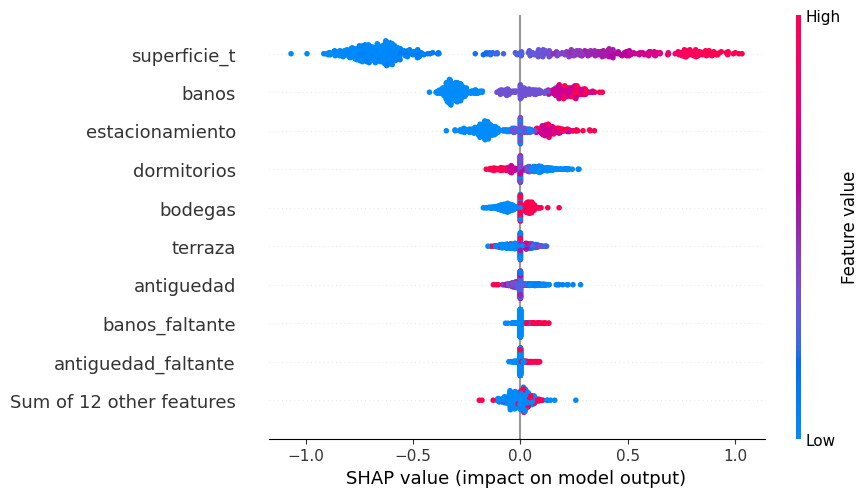

In [9]:
# Crea el objeto Explanation (opcional si explainer ya devuelve esto)
shap_values_ftt = shap.Explanation(
    values=shap_vals_ftt,
    base_values=explainer_ftt.expected_value,
    data=X_explain,
    feature_names=feat_ftt
)

# Beeswarm plot
shap.plots.beeswarm(shap_values_ftt, show=True)


In [ ]:
# --- Parámetros SHAP (FTT) ---
TOPK = 20

# Sanidad de formas (mantén esto igual)
shap_vals_ftt = np.asarray(shap_vals_ftt)
if shap_vals_ftt.ndim == 1:
    shap_vals_ftt = shap_vals_ftt.reshape(-1, 1)
if shap_vals_ftt.shape[0] != X_explain.shape[0] and shap_vals_ftt.shape[1] == X_explain.shape[0]:
    shap_vals_ftt = shap_vals_ftt.T
assert shap_vals_ftt.shape[1] == len(feat_ftt), f"mismatch: {shap_vals_ftt.shape} vs {len(feat_ftt)}"

# Importancias y signo
mean_shap_ftt = np.mean(shap_vals_ftt, axis=0)          # efecto promedio (firmado)
imp_ftt       = np.mean(np.abs(shap_vals_ftt), axis=0)   # importancia global (abs)
order_ftt     = np.argsort(imp_ftt)[::-1]
sign_char_ftt = np.where(mean_shap_ftt >= 0, "+", "-")

shap_top_ftt = pd.DataFrame({
    "feature": np.array(feat_ftt)[order_ftt][:TOPK],
    "sign": sign_char_ftt[order_ftt][:TOPK],
    "mean_|shap|": imp_ftt[order_ftt][:TOPK],
    "mean_shap": mean_shap_ftt[order_ftt][:TOPK],        # opcional, magnitud firmada
})
print("\n[FTT] Top-20 features por |SHAP| con signo:")
print(shap_top_ftt.to_string(index=False))



[FTT] Top-20 features por |SHAP| con signo:
             feature sign  mean_|shap|  mean_shap
        superficie_t    -     0.567280  -0.143784
               banos    -     0.225708  -0.062129
     estacionamiento    -     0.134954  -0.036816
         dormitorios    +     0.070326   0.027907
             bodegas    -     0.050871  -0.014029
             terraza    -     0.043624  -0.007455
          antiguedad    +     0.033760   0.008417
      banos_faltante    +     0.009007   0.005060
 antiguedad_faltante    +     0.008981   0.002728
                Or_E    +     0.007165   0.000256
         Or_Faltante    +     0.006666   0.001896
       flag_Semipiso    -     0.005060  -0.000648
                Or_O    -     0.005005  -0.000682
                Or_S    +     0.004825   0.000252
   flag_Departamento    +     0.004093   0.000816
dormitorios_faltante    -     0.003745  -0.001063
   flag_Monoambiente    -     0.003700  -0.000559
     flag_Multinivel    -     0.003545  -0.001364
     

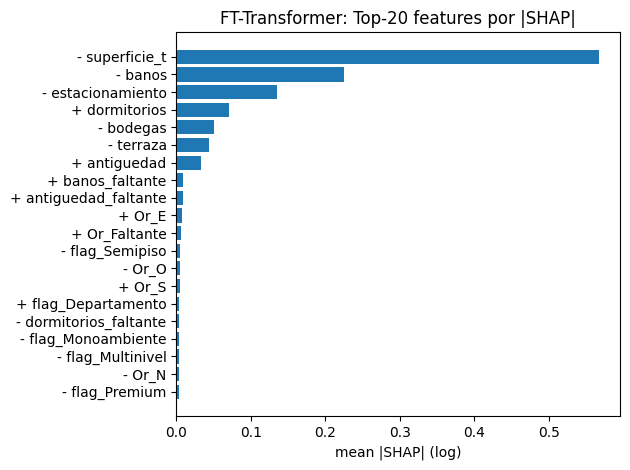

In [11]:
top = shap_top_ftt.copy()
labels = (top["sign"] + " " + top["feature"]).iloc[::-1]

plt.figure()
plt.barh(labels, top["mean_|shap|"].iloc[::-1])
plt.xlabel("mean |SHAP| (log)")
plt.title("FT-Transformer: Top-20 features por |SHAP|")
plt.tight_layout()
plt.show()

### SHAP Modelo con coordenadas FT-Transformer

In [4]:
VERSION_TAG_FTT = "v2" # ajusta: v1/v2/v3
BASE_FTT = "models_FTT"

# Configuración básica del dataset
df_vcr_c = pd.read_csv('dataset_vcr_compact.csv')
df_vcr_c = df_vcr_c[df_vcr_c['monto'] < 56000].copy()
df_vcr_c['log_monto']=np.log(df_vcr_c['monto'])

df_coord =df_vcr_c.copy()
obj_cols = df_coord.select_dtypes(include=["object"]).columns
cols_to_drop = list(obj_cols)
cols_to_drop.append("id")
df_coord = df_coord.drop(columns=cols_to_drop)

In [5]:
# === Cargar artefactos FTT ===
state = torch.load(os.path.join(BASE_FTT, f"FTT_model_{VERSION_TAG_FTT}.pt"), map_location="cuda")
with open(os.path.join(BASE_FTT, f"feature_names_FTT_{VERSION_TAG_FTT}.json"), "r") as f:
    feat_ftt = json.load(f)
scaler = joblib.load(os.path.join(BASE_FTT, f"scaler_FTT_{VERSION_TAG_FTT}.joblib"))


hp = state["hp"]
model_ftt = FTTransformer(
    n_features=len(feat_ftt),
    d_token=hp["d_token"], n_layers=hp["n_layers"], n_head=hp["n_head"], ff_mult=hp["ff_mult"], dropout=hp["dropout"],
).to("cuda").eval()
model_ftt.load_state_dict(state["model_state"]) # pesos

<All keys matched successfully>

In [6]:
# === Preparar datos ===
DF = df_coord.copy()
X_raw = DF[feat_ftt].values.astype(np.float32)
X_std = scaler.transform(X_raw).astype(np.float32)

In [7]:
# Background y subconjunto a explicar
BG_K = 64
EX_N = 128
km = shap.kmeans(X_std, BG_K)
background = km.data if hasattr(km, "data") else km
background = np.asarray(background, dtype=np.float32)
X_explain = X_std[:EX_N]

In [8]:
# Función de predicción (numpy -> torch -> numpy)
def f_pred(z: np.ndarray) -> np.ndarray:
    with torch.no_grad():
        xb = torch.from_numpy(z).to("cuda")
        out = model_ftt(xb).detach().cpu().numpy().ravel()
    return out

In [9]:
# === SHAP KernelExplainer ===
NSAMPLES = 200
explainer_ftt = shap.KernelExplainer(f_pred, background, link="identity")
shap_vals_ftt = explainer_ftt.shap_values(X_explain, nsamples=NSAMPLES)
shap_vals_ftt = np.asarray(shap_vals_ftt, dtype=np.float32)

  0%|          | 0/128 [00:00<?, ?it/s]

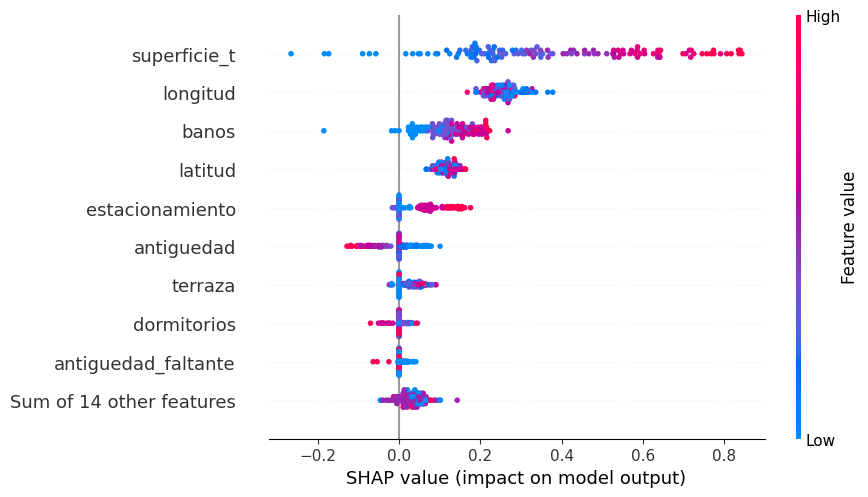

In [10]:
# Crea el objeto Explanation (opcional si explainer ya devuelve esto)
shap_values_ftt = shap.Explanation(
    values=shap_vals_ftt,
    base_values=explainer_ftt.expected_value,
    data=X_explain,
    feature_names=feat_ftt
)

# Beeswarm plot
shap.plots.beeswarm(shap_values_ftt, show=True)


In [ ]:
# --- Parámetros SHAP (FTT) ---
TOPK = 20

# Sanidad de formas (mantén esto igual)
shap_vals_ftt = np.asarray(shap_vals_ftt)
if shap_vals_ftt.ndim == 1:
    shap_vals_ftt = shap_vals_ftt.reshape(-1, 1)
if shap_vals_ftt.shape[0] != X_explain.shape[0] and shap_vals_ftt.shape[1] == X_explain.shape[0]:
    shap_vals_ftt = shap_vals_ftt.T
assert shap_vals_ftt.shape[1] == len(feat_ftt), f"mismatch: {shap_vals_ftt.shape} vs {len(feat_ftt)}"

# Importancias y signo
mean_shap_ftt = np.mean(shap_vals_ftt, axis=0)          # efecto promedio (firmado)
imp_ftt       = np.mean(np.abs(shap_vals_ftt), axis=0)   # importancia global (abs)
order_ftt     = np.argsort(imp_ftt)[::-1]
sign_char_ftt = np.where(mean_shap_ftt >= 0, "+", "-")

shap_top_ftt = pd.DataFrame({
    "feature": np.array(feat_ftt)[order_ftt][:TOPK],
    "sign": sign_char_ftt[order_ftt][:TOPK],
    "mean_|shap|": imp_ftt[order_ftt][:TOPK],
    "mean_shap": mean_shap_ftt[order_ftt][:TOPK],        # opcional, magnitud firmada
})
print("\n[FTT] Top-20 features por |SHAP| con signo:")
print(shap_top_ftt.to_string(index=False))



[FTT] Top-20 features por |SHAP| con signo:
             feature sign  mean_|shap|  mean_shap
        superficie_t    +     0.392905   0.379754
            longitud    +     0.255153   0.255153
               banos    +     0.121059   0.117733
             latitud    +     0.117809   0.117809
     estacionamiento    +     0.069305   0.068539
          antiguedad    -     0.037845  -0.009291
             terraza    +     0.033228   0.031705
         dormitorios    +     0.009006   0.002084
 antiguedad_faltante    +     0.005527   0.003257
             bodegas    +     0.005261   0.004640
       flag_Semipiso    +     0.004622   0.002630
   flag_Monoambiente    +     0.004252   0.002056
      banos_faltante    +     0.003975   0.003975
        flag_Premium    +     0.003351   0.002588
                Or_S    +     0.003218   0.002307
         Or_Faltante    +     0.003039   0.002119
                Or_O    +     0.002912   0.001635
                Or_E    +     0.002896   0.002796
     

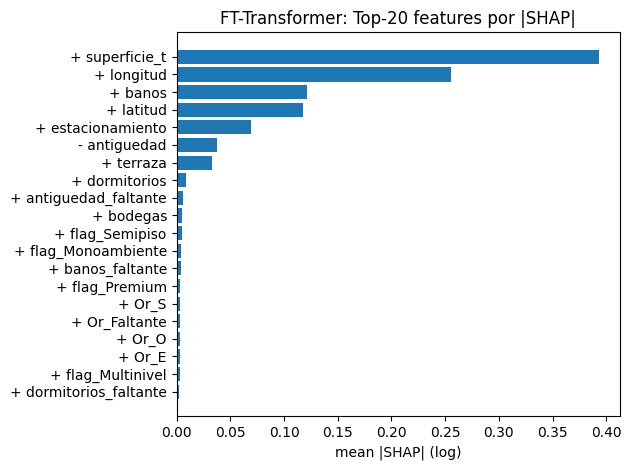

In [12]:
top = shap_top_ftt.copy()
labels = (top["sign"] + " " + top["feature"]).iloc[::-1]

plt.figure()
plt.barh(labels, top["mean_|shap|"].iloc[::-1])
plt.xlabel("mean |SHAP| (log)")
plt.title("FT-Transformer: Top-20 features por |SHAP|")
plt.tight_layout()
plt.show()

### SHAP Modelo con coordenadas y VCR FT-Transformer

In [13]:
VERSION_TAG_FTT = "v3" # ajusta: v1/v2/v3
BASE_FTT = "models_FTT"

df_vcr_e = pd.read_csv('dataset_vcr_expanded.csv')
df_vcr_e = df_vcr_e[df_vcr_e['monto'] < 56000].copy()
df_vcr_e['log_monto']=np.log(df_vcr_e['monto'])

df_vcr =df_vcr_e.copy()
obj_cols = df_vcr.select_dtypes(include=["object"]).columns
cols_to_drop = list(obj_cols)
cols_to_drop.append("id")
df_vcr = df_vcr.drop(columns=cols_to_drop)


In [14]:
# Configuración (
# Dimensiones (1..12) 
DIMS_MAP = {
    1: "count_pois",
    2: "mean_distance",
    3: "min_distance",
    4: "max_distance",
    5: "median_distance",
    6: "std_distance",
    7: "mean_inverse_distance",
    8: "max_inverse_distance",
    9: "sum_inverse_distance",
    10: "ratio_within_near_radius",
    11: "ratio_within_mid_radius",
    12: "ratio_within_far_radius",
}

# Rol por dimensión (para decidir la imputación semántica)
DIM_ROLE = {
    1: "count",                # -> 0
    2: "distance",             # -> R3
    3: "distance",             # -> R3
    4: "distance",             # -> R3
    5: "distance",             # -> R3
    6: "std",                  # -> 0
    7: "inverse",              # -> 0
    8: "inverse",              # -> 0
    9: "inverse",              # -> 0
    10: "ratio",               # -> 0
    11: "ratio",               # -> 0
    12: "ratio",               # -> 0
}

# R3 por tipo de clase
R3_DEFAULT = 2400.0  # clases generales
R3_METRO = 1600.0
R3_BUS = 800.0

# Funciones
def _class_and_dim(col: str) -> Optional[Tuple[str, int]]:
    """Extrae (clase, índice de dimensión) de columnas tipo '<clase>_dimXX'."""
    m = re.match(r"^(?P<klass>.+)_dim(?P<idx>\d{1,2})$", col)
    if not m:
        return None
    return m.group("klass"), int(m.group("idx"))


def _r3_for_class(klass: str) -> float:
    k = klass.lower()
    if "metro" in k:
        return R3_METRO
    if "bus" in k:
        return R3_BUS
    return R3_DEFAULT


def impute_vcr_semantic(df: pd.DataFrame) -> pd.DataFrame:
    """Imputa VCR por semántica de ausencia: distancias=R3, inversas/ratios=0, count=0, std=0.
    Además agrega flags `has_<clase>` indicando presencia de POIs por clase.
    """
    out = df.copy()

    # Agrupar columnas por clase
    groups: Dict[str, Dict[int, str]] = {}
    vcr_cols = []
    for c in out.columns:
        parsed = _class_and_dim(c)
        if parsed is None:
            continue
        klass, idx = parsed
        groups.setdefault(klass, {})[idx] = c
        vcr_cols.append(c)

    if not groups:
        # Nada que imputar
        return out

    # Flags de presencia por clase (antes de imputar)
    for klass, dim_map in groups.items():
        cols = list(dim_map.values())
        has_series = out[cols].notna().any(axis=1).astype("int64")
        out[f"has_{klass}"] = has_series  # por qué: distingue ausencia real vs lejanía

    # Imputación por clase/dim
    n_total_nans = int(out[vcr_cols].isna().sum().sum())
    for klass, dim_map in groups.items():
        r3 = _r3_for_class(klass)
        for idx, col in dim_map.items():
            role = DIM_ROLE.get(idx)
            if role == "distance":
                fill_value = r3
            elif role in {"inverse", "ratio", "std", "count"}:
                fill_value = 0.0
            else:
                # Si hay una dimensión desconocida, ser conservador con 0.0
                fill_value = 0.0
            out[col] = out[col].fillna(fill_value)

    n_after_nans = int(out[vcr_cols].isna().sum().sum())
    print(f"Imputación VCR completada. NaNs antes: {n_total_nans:,d} -> después: {n_after_nans:,d}")

    return out



df_vcr_imp = impute_vcr_semantic(df_vcr)
df_vcr_imp.info()  

Imputación VCR completada. NaNs antes: 246,228 -> después: 0
<class 'pandas.core.frame.DataFrame'>
Index: 25211 entries, 0 to 25214
Columns: 194 entries, monto to has_bus
dtypes: float64(161), int64(33)
memory usage: 37.5 MB


In [15]:
# === Cargar artefactos FTT ===
state = torch.load(os.path.join(BASE_FTT, f"FTT_model_{VERSION_TAG_FTT}.pt"), map_location="cuda")
with open(os.path.join(BASE_FTT, f"feature_names_FTT_{VERSION_TAG_FTT}.json"), "r") as f:
    feat_ftt = json.load(f)
scaler = joblib.load(os.path.join(BASE_FTT, f"scaler_FTT_{VERSION_TAG_FTT}.joblib"))


hp = state["hp"]
model_ftt = FTTransformer(
    n_features=len(feat_ftt),
    d_token=hp["d_token"], n_layers=hp["n_layers"], n_head=hp["n_head"], ff_mult=hp["ff_mult"], dropout=hp["dropout"],
).to("cuda").eval()
model_ftt.load_state_dict(state["model_state"]) # pesos

<All keys matched successfully>

In [16]:
# === Preparar datos ===
DF = df_vcr_imp.copy()
X_raw = DF[feat_ftt].values.astype(np.float32)
X_std = scaler.transform(X_raw).astype(np.float32)

In [18]:
# Background y subconjunto a explicar
BG_K = 32
EX_N = 64
km = shap.kmeans(X_std, BG_K)
background = km.data if hasattr(km, "data") else km
background = np.asarray(background, dtype=np.float32)
X_explain = X_std[:EX_N]

In [19]:
# Función de predicción (numpy -> torch -> numpy)
def f_pred(z: np.ndarray) -> np.ndarray:
    with torch.no_grad():
        xb = torch.from_numpy(z).to("cuda")
        out = model_ftt(xb).detach().cpu().numpy().ravel()
    return out

In [20]:
# === SHAP KernelExplainer ===
NSAMPLES = 200
explainer_ftt = shap.KernelExplainer(f_pred, background, link="identity")
shap_vals_ftt = explainer_ftt.shap_values(X_explain, nsamples=NSAMPLES)
shap_vals_ftt = np.asarray(shap_vals_ftt, dtype=np.float32)

  0%|          | 0/64 [00:00<?, ?it/s]

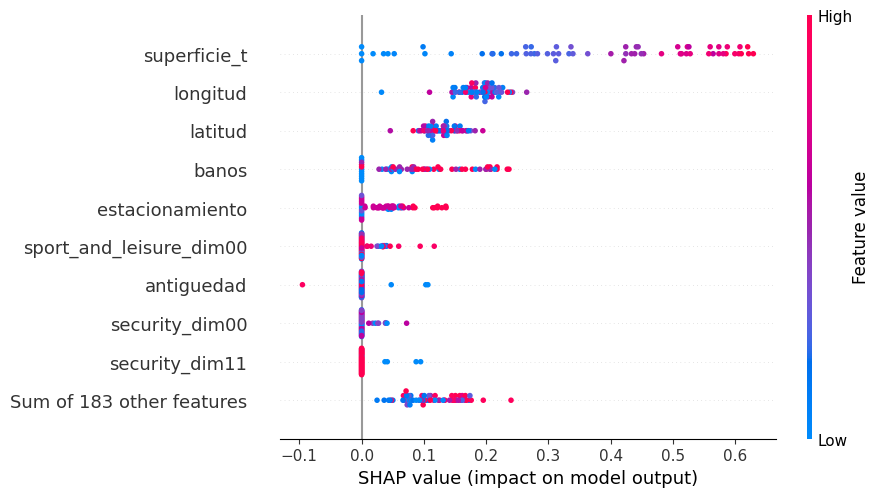

In [21]:
# Crea el objeto Explanation (opcional si explainer ya devuelve esto)
shap_values_ftt = shap.Explanation(
    values=shap_vals_ftt,
    base_values=explainer_ftt.expected_value,
    data=X_explain,
    feature_names=feat_ftt
)

# Beeswarm plot
shap.plots.beeswarm(shap_values_ftt, show=True)


In [ ]:
# --- Parámetros SHAP (FTT) ---
TOPK = 20

# Sanidad de formas (mantén esto igual)
shap_vals_ftt = np.asarray(shap_vals_ftt)
if shap_vals_ftt.ndim == 1:
    shap_vals_ftt = shap_vals_ftt.reshape(-1, 1)
if shap_vals_ftt.shape[0] != X_explain.shape[0] and shap_vals_ftt.shape[1] == X_explain.shape[0]:
    shap_vals_ftt = shap_vals_ftt.T
assert shap_vals_ftt.shape[1] == len(feat_ftt), f"mismatch: {shap_vals_ftt.shape} vs {len(feat_ftt)}"

# Importancias y signo
mean_shap_ftt = np.mean(shap_vals_ftt, axis=0)          # efecto promedio (firmado)
imp_ftt       = np.mean(np.abs(shap_vals_ftt), axis=0)   # importancia global (abs)
order_ftt     = np.argsort(imp_ftt)[::-1]
sign_char_ftt = np.where(mean_shap_ftt >= 0, "+", "-")

shap_top_ftt = pd.DataFrame({
    "feature": np.array(feat_ftt)[order_ftt][:TOPK],
    "sign": sign_char_ftt[order_ftt][:TOPK],
    "mean_|shap|": imp_ftt[order_ftt][:TOPK],
    "mean_shap": mean_shap_ftt[order_ftt][:TOPK],        # opcional, magnitud firmada
})
print("\n[FTT] Top-20 features por |SHAP| con signo:")
print(shap_top_ftt.to_string(index=False))



[FTT] Top-20 features por |SHAP| con signo:
                     feature sign  mean_|shap|  mean_shap
                superficie_t    +     0.369989   0.369989
                    longitud    +     0.189760   0.189760
                     latitud    +     0.129198   0.129198
                       banos    +     0.097200   0.097200
             estacionamiento    +     0.042373   0.042373
     sport_and_leisure_dim00    +     0.011241   0.011241
                  antiguedad    +     0.005499   0.002531
              security_dim00    +     0.004597   0.004597
              security_dim11    +     0.004077   0.004077
arts_and_entertainment_dim10    +     0.003720   0.003720
             park_like_dim07    +     0.003654   0.003654
         education_sup_dim02    +     0.003182   0.003182
                     bodegas    +     0.002862   0.002862
     sport_and_leisure_dim05    +     0.002605   0.002605
        education_prim_dim04    +     0.002259   0.002259
        education_prim_dim0

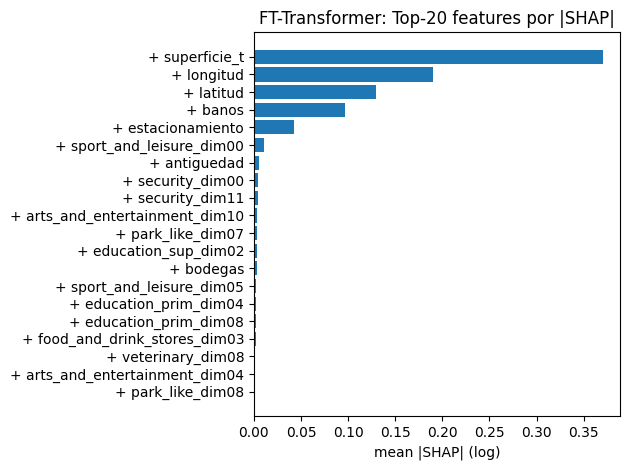

In [23]:
top = shap_top_ftt.copy()
labels = (top["sign"] + " " + top["feature"]).iloc[::-1]

plt.figure()
plt.barh(labels, top["mean_|shap|"].iloc[::-1])
plt.xlabel("mean |SHAP| (log)")
plt.title("FT-Transformer: Top-20 features por |SHAP|")
plt.tight_layout()
plt.show()


In [19]:
#Si bien 12 de las 20 features mas importantes son parte de los VCR, su impacto sigue siendo infimo...